## Mount Google Drive to Colab-Notebook and import packages and config file

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd 'drive/My Drive/Probabilistic-U-Net-Evaluation-Wue_Lab'

/content/drive/My Drive/Probabilistic-U-Net-Evaluation-Wue_Lab


In [3]:
import os
import numpy as np
import matplotlib
import matplotlib.gridspec as gridspec
from pandas.core.common import flatten
from glob import glob
import seaborn as sns
import pandas as pd
import imp 
import pickle
from random import randrange

from utils.mg_utils import iou, calculate_roi_measures

In [4]:
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline

In [5]:
cf = imp.load_source('cf', 'evaluation/wue_lab_eval_config.py')
path = cf.out_dir

## Calculate mean IoU (6 samples)

In [6]:
#set seed for reproducibility
np.random.seed(0)

In [7]:
def batch_six(cf):

    """Assembles a batch of the testset with microscopic scan and its respective segmentation
    masks from experts and six model samples as well as average masks from those.
    """

    img, seg, ids, samples, avg_masks, avg_experts = [], [], [], [], [], []
    img_ixs = glob(os.path.join(cf.out_dir, 'images', '*'))

    for i in range(len(img_ixs)):
        # get the first image for the patient
        img_path = img_ixs[i]
        pth_split = img_path.rsplit('/', 1)[-1][:-4]
        ids.append(pth_split)

        image = np.load(img_path)
        #image = image[np.newaxis, np.newaxis, ...]
        img.append(image)

        # get the corresponding ground truth label
        gt_base_path = img_path.replace('images', 'gt')
        # Für alle 4 Expertenmasken zu bestimmtem Bild:
        labels = []
        for l in range(cf.num_graders):
            gt_path = gt_base_path.replace('.npy', '_l{}.npy'.format(l))
            label = np.load(gt_path)
            labels.append(label)
        labels = np.concatenate(labels, axis=1)
        avg_expert = np.sum(labels, axis = 1)
        avg_experts.append(avg_expert)
        seg.append(labels)
        
        # Samples
        sample_base_path = img_path.replace('images/', '')
        sample_list = []
        for i in range(cf.num_samples):
            new_path = sample_base_path.replace('.npy', '_sample{}.npy'.format(i))
            sample = np.load(new_path)
            sample_list.append(sample)
        array = np.concatenate(sample_list, axis=1)
        avg_mask = np.sum(array, axis = 1)
        avg_masks.append(avg_mask)
        samples.append(array)
    
    # Concat and rearrange np arrays for BHWC format
    img_batch = np.concatenate(img, axis=0)
    img_batch = np.transpose(img_batch, (0, 2, 3, 1))
    seg_batch = np.concatenate(seg, axis=0)
    seg_batch = np.transpose(seg_batch, (0, 2, 3, 1))
    sample_batch = np.concatenate(samples, axis=0)
    sample_batch = np.transpose(sample_batch, (0, 2, 3, 1))
    avg_expert_batch = np.concatenate(avg_experts, axis=0)
    avg_mask_batch = np.concatenate(avg_masks, axis=0)
   

    batch = {'data': np.array(img_batch).astype('float32'), 'seg': np.array(seg_batch).astype('uint8'),
             'sample': np.array(sample_batch).astype('uint8'), 'avg_masks': np.array(avg_mask_batch).astype('uint8'),
             'avg_experts': np.array(avg_expert_batch).astype('uint8'), 'id': ids}

    return batch

In [8]:
batch = batch_six(cf)

### Define and calculate mean IoU with six Samples

In [10]:
def mean_iou(mask_list1, mask_list2):
    
    ious = []
    length = len(mask_list1)
    
    for i in range(length):
        single_iou = iou(mask_list1[i], mask_list2[i])
        ious.append(single_iou)

    mean_iou = sum(ious)/length
    
    return mean_iou, ious

In [11]:
ds_iou = mean_iou(batch['avg_masks'], batch['avg_experts']); ds_iou[0]

0.4212922468818963

### Plot mean IoUs for each testset instance

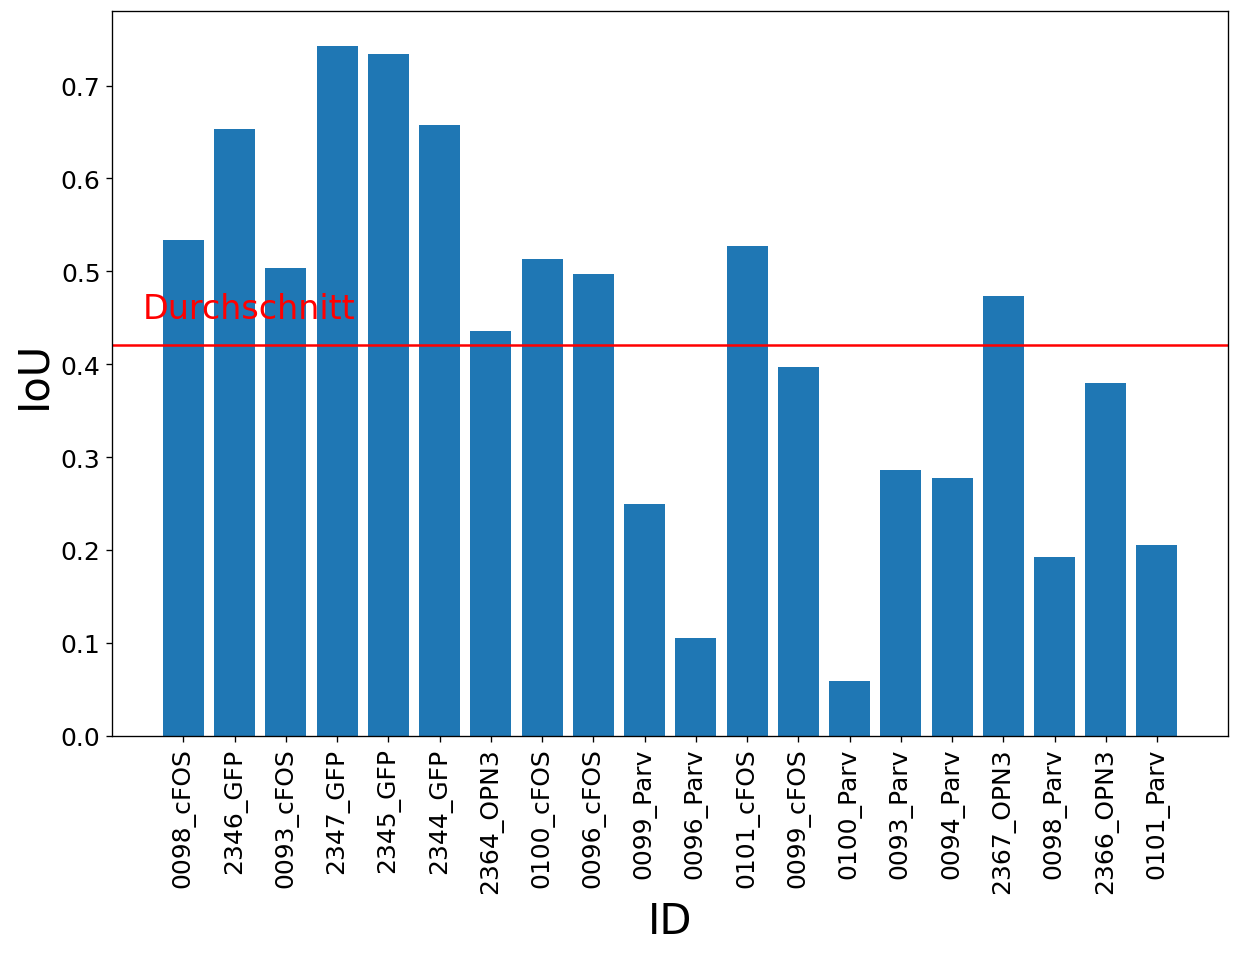

In [12]:
fig=plt.figure(figsize=(12,8), dpi=120)
plt.bar(x=batch['id'],height=ds_iou[1])
plt.ylabel('IoU').set_fontsize(25)
plt.xlabel('ID').set_fontsize(25)
plt.xticks(fontsize = 15, rotation=90)
plt.yticks(fontsize = 15)
plt.text(16,0.42, 'Durchschnitt', color = 'r', fontsize=20)
plt.axhline(ds_iou[0], color='r')
plt.savefig(os.path.join(cf.out_dir, 'plots/ds_mean_ious.png'), bbox_inches='tight')

### Create subtestsets containing only one type of subdataset and get mean IoUs

In [13]:
def get_sublist(ds_string, batch):
    indices = [s for s, n in enumerate(batch['id']) if ds_string in n]
    
    id_list = [batch['id'][i] for i in indices]
    sample_avg_list = [batch['avg_masks'][i] for i in indices]
    exp_avg_list = [batch['avg_experts'][i] for i in indices]
    
    batch = {'avg_masks': np.array(sample_avg_list), 'avg_experts': np.array(exp_avg_list), 'id': id_list}
    
    return batch

In [14]:
parv_list = get_sublist('Parv', batch)
gfp_list = get_sublist('GFP', batch)
opn_list = get_sublist('OPN3', batch)
cfos_list = get_sublist('cFOS', batch)

In [15]:
parv_iou = mean_iou(parv_list['avg_masks'], parv_list['avg_experts']); parv_iou[0]

0.19666755591125337

In [16]:
gfp_iou = mean_iou(gfp_list['avg_masks'], gfp_list['avg_experts']); gfp_iou[0]

0.6970762997580793

In [17]:
opn_iou = mean_iou(opn_list['avg_masks'], opn_list['avg_experts']); opn_iou[0]

0.42991213293486524

In [18]:
cfos_iou = mean_iou(cfos_list['avg_masks'], cfos_list['avg_experts']); cfos_iou[0]

0.49518840807037345

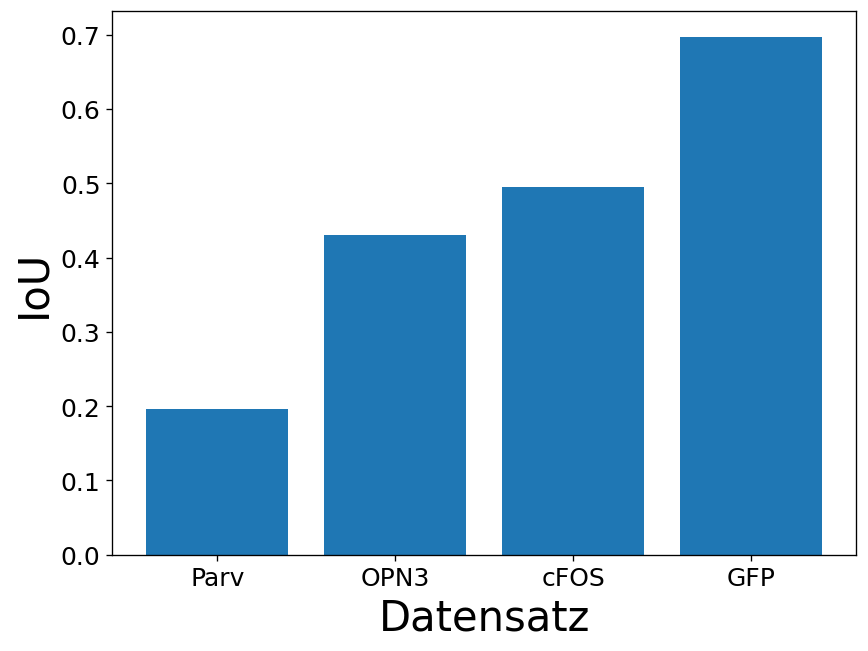

In [19]:
subds_ious = [parv_iou[0], opn_iou[0], cfos_iou[0], gfp_iou[0]]
labels = ['Parv', 'OPN3', 'cFOS', 'GFP']
fig=plt.figure(figsize=(8,6), dpi=120)
plt.bar(x=labels,height=subds_ious)
plt.ylabel('IoU').set_fontsize(25)
plt.xlabel('Datensatz').set_fontsize(25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.savefig(os.path.join(cf.out_dir, 'plots/subds_mean_ious.png'), bbox_inches='tight')

## Calculate mean IoU (3 samples)

In [20]:
def batch_three(cf):

    """Assembles a batch of the testset with microscopic scan and its respective segmentation
    masks from experts and three model samples as well as average masks from those.
    """

    img, seg, ids, samples, avg_masks, avg_experts = [], [], [], [], [], []
    img_ixs = glob(os.path.join(cf.out_dir, 'images', '*'))

    for i in range(len(img_ixs)):
        # get the first image for the patient
        img_path = img_ixs[i]
        pth_split = img_path.rsplit('/', 1)[-1][:-4]
        ids.append(pth_split)

        image = np.load(img_path)
        #image = image[np.newaxis, np.newaxis, ...]
        img.append(image)

        # get the corresponding ground truth label
        gt_base_path = img_path.replace('images', 'gt')
        # Für alle 4 Expertenmasken zu bestimmtem Bild:
        labels = []
        for l in range(cf.num_graders):
            gt_path = gt_base_path.replace('.npy', '_l{}.npy'.format(l))
            label = np.load(gt_path)
            labels.append(label)
        labels = np.concatenate(labels, axis=1)
        avg_expert = np.sum(labels, axis = 1)
        avg_experts.append(avg_expert)
        seg.append(labels)
        
        # Samples
        sample_base_path = img_path.replace('images/', '')
        sample_list = []
        for i in range(cf.num_graders):
            new_path = sample_base_path.replace('.npy', '_sample{}.npy'.format(i))
            sample = np.load(new_path)
            sample_list.append(sample)
        array = np.concatenate(sample_list, axis=1)
        avg_mask = np.sum(array, axis = 1)
        avg_masks.append(avg_mask)
        samples.append(array)
    
    # Concat and rearrange np arrays for BHWC format
    img_batch = np.concatenate(img, axis=0)
    img_batch = np.transpose(img_batch, (0, 2, 3, 1))
    seg_batch = np.concatenate(seg, axis=0)
    seg_batch = np.transpose(seg_batch, (0, 2, 3, 1))
    sample_batch = np.concatenate(samples, axis=0)
    sample_batch = np.transpose(sample_batch, (0, 2, 3, 1))
    avg_expert_batch = np.concatenate(avg_experts, axis=0)
    avg_mask_batch = np.concatenate(avg_masks, axis=0)
   

    batch = {'data': np.array(img_batch).astype('float32'), 'seg': np.array(seg_batch).astype('uint8'),
             'sample': np.array(sample_batch).astype('uint8'), 'avg_masks': np.array(avg_mask_batch).astype('uint8'),
             'avg_experts': np.array(avg_expert_batch).astype('uint8'), 'id': ids}

    return batch

In [21]:
batch = batch_three(cf)

In [22]:
ds_iou = mean_iou(batch['avg_masks'], batch['avg_experts']); ds_iou[0]

0.40433054610995434

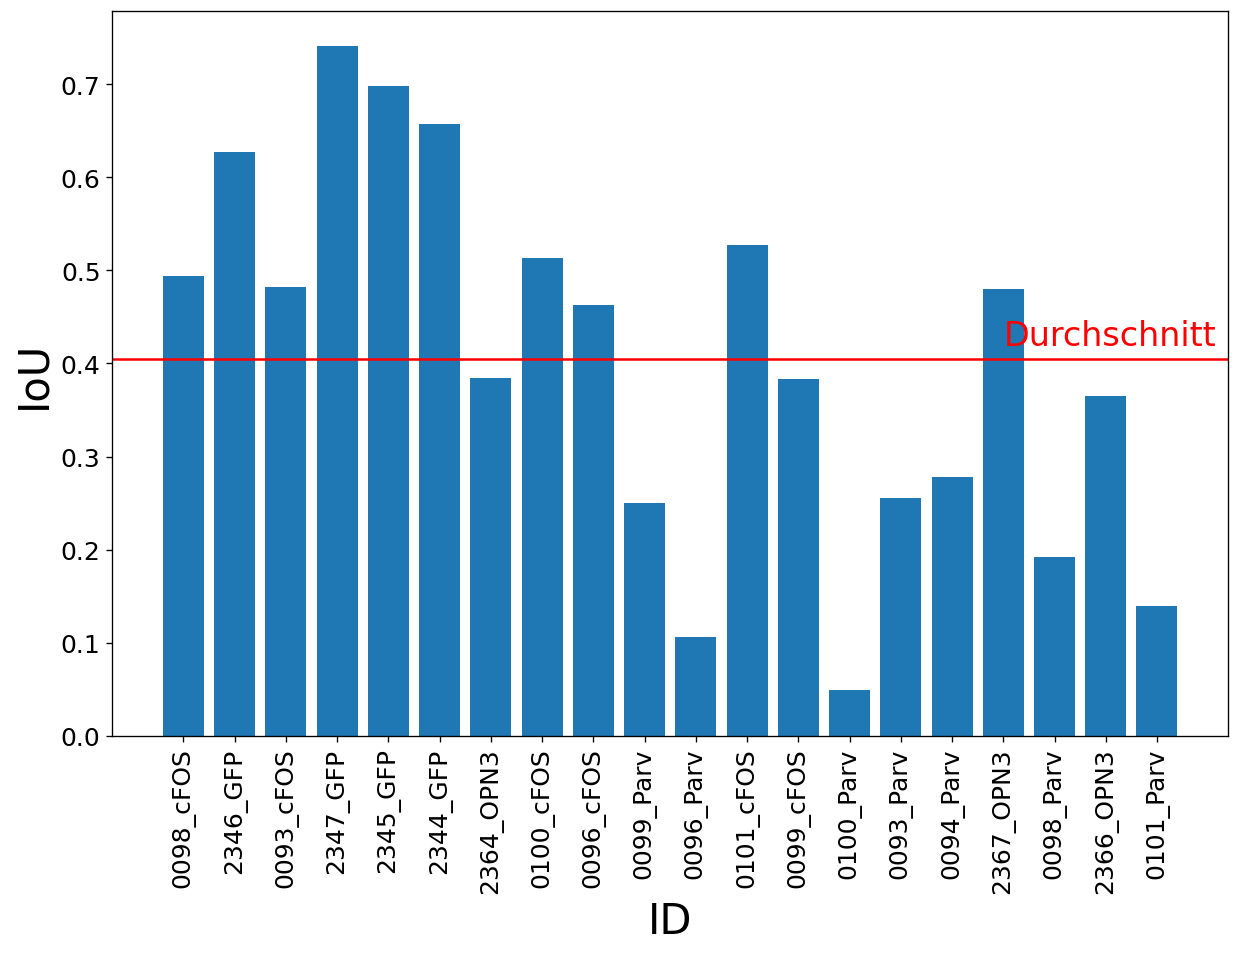

In [36]:
fig=plt.figure(figsize=(12,8), dpi=120)
plt.bar(x=batch['id'],height=ds_iou[1])
plt.ylabel('IoU').set_fontsize(25)
plt.xlabel('ID').set_fontsize(25)
plt.xticks(fontsize = 15, rotation=90)
plt.yticks(fontsize = 15)
plt.axhline(ds_iou[0], color='r')
plt.text(16,0.42, 'Durchschnitt', color = 'r', fontsize=20)
plt.savefig(os.path.join(cf.out_dir, 'plots/3_samples_ds_mean_ious.png'), bbox_inches='tight')

In [24]:
parv_list = get_sublist('Parv', batch)
gfp_list = get_sublist('GFP', batch)
opn_list = get_sublist('OPN3', batch)
cfos_list = get_sublist('cFOS', batch)

In [37]:
parv_iou = mean_iou(parv_list['avg_masks'], parv_list['avg_experts']); parv_iou[0]

0.18151675875028372

In [38]:
gfp_iou = mean_iou(gfp_list['avg_masks'], gfp_list['avg_experts']); gfp_iou[0]

0.6810243142142305

In [39]:
opn_iou = mean_iou(opn_list['avg_masks'], opn_list['avg_experts']); opn_iou[0]

0.4099662239540573

In [40]:
cfos_iou = mean_iou(cfos_list['avg_masks'], cfos_list['avg_experts']); cfos_iou[0]

0.4769996137046681

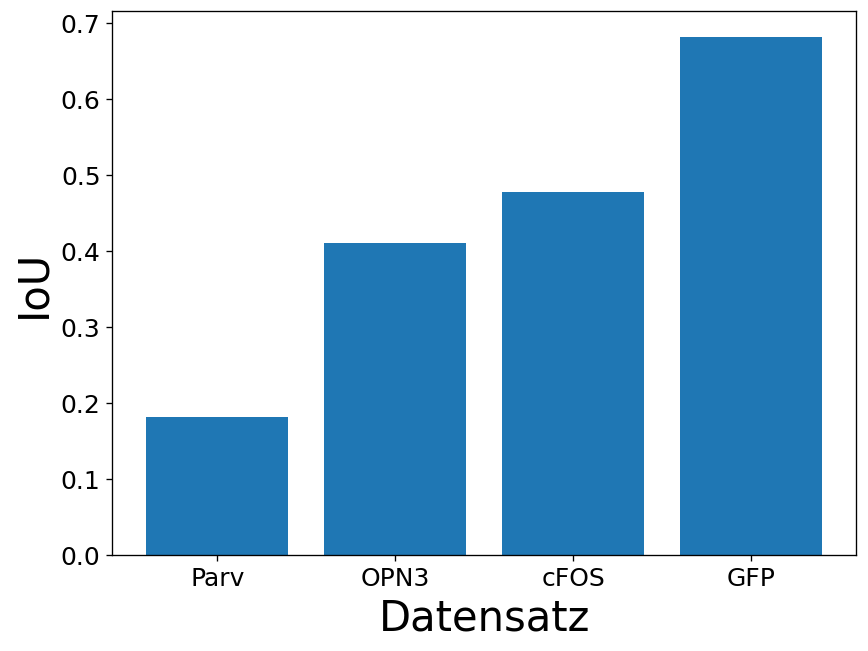

In [41]:
subds_ious = [parv_iou[0], opn_iou[0], cfos_iou[0], gfp_iou[0]]
labels = ['Parv', 'OPN3', 'cFOS', 'GFP']
fig=plt.figure(figsize=(8,6), dpi=120)
plt.bar(x=labels,height=subds_ious)
plt.ylabel('IoU').set_fontsize(25)
plt.xlabel('Datensatz').set_fontsize(25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.savefig(os.path.join(cf.out_dir, 'plots/3_samples_subds_mean_ious.png'), bbox_inches='tight')

## Calculate Generalized Energy Distance (GED): 6 Samples

In [42]:
batch = batch_six(cf)

In [43]:
batch['seg'].shape, batch['sample'].shape[-1]

((20, 128, 128, 3), 6)

### Define functions for getting GED of one testset instance and whole testset

In [44]:
def ged_matrix(mask_list1, mask_list2):
    
    length1 = mask_list1.shape[-1]
    length2 = mask_list2.shape[-1]
    matrix = np.zeros(shape=(length1, length2))
    
    for i in range(length1):
        for j in range(length2):
                 single_iou = iou(mask_list1[...,i], mask_list2[...,j])
                 matrix[i,j] = 1 - single_iou
                    
    matrix_sum = np.sum(matrix)
    
    return matrix, matrix_sum

In [45]:
def calc_ged_one(expert_masks, sample_masks):
    
    d_matrix_YS, d_matrix_YS_sum = ged_matrix(expert_masks, sample_masks)
    d_matrix_SS, d_matrix_SS_sum = ged_matrix(sample_masks, sample_masks)
    d_matrix_YY, d_matrix_YY_sum = ged_matrix(expert_masks, expert_masks)
    
    d_YS = d_matrix_YS_sum/(d_matrix_YS.shape[0]*d_matrix_YS.shape[1])
    d_SS = d_matrix_SS_sum/(d_matrix_SS.shape[0]*d_matrix_SS.shape[1]-d_matrix_SS.shape[0])
    d_YY = d_matrix_YY_sum/(d_matrix_YY.shape[0]*d_matrix_YY.shape[1]-d_matrix_YY.shape[0])
    
    
    GED = 2*d_YS - d_SS - d_YY
    
    return GED, d_YS, d_SS, d_YY

In [46]:
def calc_ged_ds(expert_masks, sample_masks):
    
    GED_list, d_YS_list, d_SS_list, d_YY_list = [], [], [], []
    ds_size = expert_masks.shape[0]
    
    for i in range(ds_size):
        GED, d_YS, d_SS, d_YY = calc_ged_one(expert_masks[i], sample_masks[i])
        GED_list.append(GED)
        d_YS_list.append(d_YS)
        d_SS_list.append(d_SS)
        d_YY_list.append(d_YY)
    
    ds_GED = sum(GED_list)/ds_size
    ds_d_YS = sum(d_YS_list)/ds_size
    ds_d_SS = sum(d_SS_list)/ds_size
    ds_d_YY = sum(d_YY_list)/ds_size
    
    return ds_GED, ds_d_YS, ds_d_SS,  ds_d_YY

### Calculate GED for 6-sample-testset

In [47]:
ds_ged, ds_d_ys, ds_d_ss, ds_d_yy = calc_ged_ds(batch['seg'], batch['sample'])

In [48]:
ds_ged, ds_d_ys, ds_d_ss, ds_d_yy

(0.3866316872616144,
 0.5334469613234407,
 0.18674005803757165,
 0.4935221773476951)

## Calculate Generalized Energy Distance (GED): 3 Samples

In [49]:
batch = batch_three(cf)

In [50]:
ds3_ged, ds3_d_ys, ds3_d_ss, ds3_d_yy = calc_ged_ds(batch['seg'], batch['sample'])

In [51]:
ds3_ged, ds3_d_ys, ds3_d_ss, ds3_d_yy

(0.41657858571764556,
 0.5311065612417176,
 0.15211235941809456,
 0.4935221773476951)

### Plot metrics for 3- and 6-sample-testset

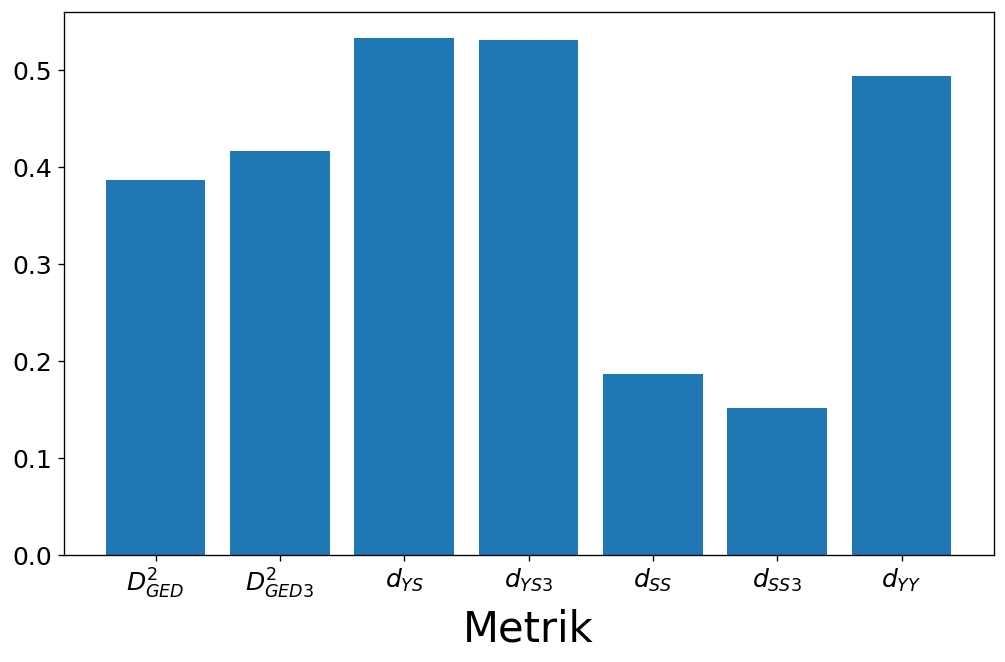

In [52]:
data = [ds_ged, ds3_ged, ds_d_ys, ds3_d_ys, ds_d_ss, ds3_d_ss, ds_d_yy]
labels = ['$D^2_{GED}$', '$D^2_{GED3}$', '$d_{YS}$', '$d_{YS3}$', '$d_{SS}$', '$d_{SS3}$', '$d_{YY}$']
fig=plt.figure(figsize=(10,6), dpi=120)
plt.bar(x=labels,height=data)
plt.xlabel('Metrik').set_fontsize(25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.savefig(os.path.join(cf.out_dir, 'plots/distance_metrics.png'), bbox_inches='tight')